## **Исходные данные:**

Обучите модель линейной регрессии на найденных двумя способами трёх важных признаках и сравните полученные результаты.

КРИТЕРИИ ОЦЕНИВАНИЯ:
1. Верно выделены три столбца-признака для обучения, выбранные RFE.
2. Верно выделены три столбца-признака для обучения, выбранные SelectKBest.
3. Обучена регрессия на первых трёх столбцах, оценено качество модели на тесте.
4. Обучена регрессия на вторых трёх столбцах, оценено качество модели на тесте.
5.Произведено сравнение выбранных метрик в форме комментария. Дан ответ на вопрос «Какой метод отбора признаков показал наилучший результат на тестовой выборке?» (в текстовой ячейке).

## **Решение:**

In [26]:
# Подключаем библиотеки
import pandas as pd
!pip install category_encoders
import category_encoders as ce
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

**Загрузка и обработка данных**

In [27]:
%%capture
!wget https://www.dropbox.com/s/64ol9q9ssggz6f1/data_ford_price.xlsx

In [28]:
# Загружаем данные
df = pd.read_excel('data_ford_price.xlsx')

In [29]:
# Выводим несколько первых строк датафрейма
display(df.head(2))
# Выводим несколько последних строк датафрейма
display(df.tail(2))

,price,year,condition,cylinders,odometer,title_status,transmission,drive,size,lat,long,weather
0,43900,2016,4,6,43500,clean,automatic,4wd,full-size,36.471500,-82.483400,59.0
1,15490,2009,2,8,98131,clean,automatic,4wd,full-size,40.468826,-74.281734,52.0


,price,year,condition,cylinders,odometer,title_status,transmission,drive,size,lat,long,weather
7015,10900,2011,2,8,164000,clean,automatic,4wd,full-size,43.1406,-93.3850,47.0
7016,18000,2010,2,8,104000,clean,automatic,4wd,full-size,37.9872,-84.1789,50.0


In [30]:
# Размерность датафрейма
df.shape

(7017, 12)

**Проверим датафрейм на наличие пропусков и дубликатов, а также на корректность типов данных столбцов**

In [31]:
# Выводим основную информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         7017 non-null   int64  
 1   year          7017 non-null   int64  
 2   condition     7017 non-null   int64  
 3   cylinders     7017 non-null   int64  
 4   odometer      7017 non-null   int64  
 5   title_status  7017 non-null   object 
 6   transmission  7017 non-null   object 
 7   drive         6626 non-null   object 
 8   size          5453 non-null   object 
 9   lat           7017 non-null   float64
 10  long          7017 non-null   float64
 11  weather       6837 non-null   float64
dtypes: float64(3), int64(5), object(4)
memory usage: 658.0+ KB


In [32]:
# Выполним проверку на наличие пропущенных значений NaN в датафрейме
df.isna().sum()

,0
price,0
year,0
condition,0
cylinders,0
odometer,0
title_status,0
transmission,0
drive,391
size,1564
lat,0


Как видно, пропущенные значения имеются в столбцах: drive - 391 пропущенных значения, size - 1564 пропущенных значений, weather - 180 пропущенных значений.

Для обработки пропусков воспользуемся **методом fillna**, который поможет  сохранить распределение данных в рассматриваемых столбцах: drive, size, weather.

In [33]:
# Обработуем пропущенные значения методом fillna
df['drive'] = df['drive'].fillna(df['drive'].value_counts().index[0]) # пропущенные значения заменим наиболее часто встречающимся значением
df['size'] = df['size'].fillna(df['size'].value_counts().index[0]) # пропущенные значения заменим наиболее часто встречающимся значением
df['weather'] = df['weather'].fillna(df['weather'].median()) # пропущенные значения заполним медианным значениями

In [34]:
# Проверка на наличие дубликатов
dupl_columns = list(df.columns) # создаем список столбцов dupl_columns, по которым будем искать совпадения
# Создаем маску дубликатов с помощью метода duplicated() и произведём фильтрацию
mask = df.duplicated(subset=dupl_columns)
df_duplicates = df[mask]
print(f'Количество найденных дубликатов: {df_duplicates.shape[0]}')

Количество найденных дубликатов: 2290


In [35]:
# Выведим строки, которые являются полными дубликатами, т.е совпадают по всем столбцам
duplicates = df[df.duplicated()]
print("Строки, которые являются полными дубликатами:")
print(duplicates)

Строки, которые являются полными дубликатами:
      price  year  condition  cylinders  odometer title_status transmission  \
94    19550  2011          3          8     95372        clean    automatic   
103       1  2014          3          6    117123        clean    automatic   
158   13995  2008          3          8    105033        clean    automatic   
184     999  2011          2          8     85000        clean    automatic   
223       1  1997          2          8    247500        clean    automatic   
...     ...   ...        ...        ...       ...          ...          ...   
7004  31500  2017          3          6      7105        clean    automatic   
7006   9900  2009          2          8     97697        clean    automatic   
7010  62995  2017          3          6     22973        clean    automatic   
7014   9999  2006          3          8    161514        clean    automatic   
7015  10900  2011          2          8    164000        clean    automatic   

     

Как видно из проведенного анализа в датафрейме присутствуют полные дубликаты в колличестве 2290 шт, которые следует удалить по следующим причинам:
* так как одна и та же запись появляется несколько раз, это может привести к смещению модели, т.е. одинаковые данные будут переоцениваться и соответственно искажать модель;
* удаление дубликатов позволит сократить размер данных и соответственно ускорить обучение модели.

In [36]:
# Удалим дубликаты
df = df.drop_duplicates(subset=dupl_columns)
print('Размер таблицы после удаления дубликатов: {}'.format(df.shape))

Размер таблицы после удаления дубликатов: (4727, 12)


Перекодируем столбцы title_status, transmission, drive и size с использованием метода порядкового кодирования (Ordinal Encoding), без создания дополнительных столбцов


In [37]:
from sklearn.preprocessing import OrdinalEncoder

# Столбцы для перекодирования
columns_to_encode = ['title_status', 'transmission', 'drive', 'size']

# Создаем объект OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

# Применяем OrdinalEncoder ко всем указанным столбцам
df[columns_to_encode] = ordinal_encoder.fit_transform(df[columns_to_encode])

# Проверяем результат
print(df[columns_to_encode].head())

   title_status  transmission  drive  size
0           0.0           0.0    0.0   1.0
1           0.0           0.0    0.0   1.0
2           0.0           0.0    0.0   1.0
3           3.0           0.0    0.0   1.0
4           0.0           0.0    0.0   1.0


<ipython-input-37-3347825965ea>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns_to_encode] = ordinal_encoder.fit_transform(df[columns_to_encode])


**Удаление избыточного признака**

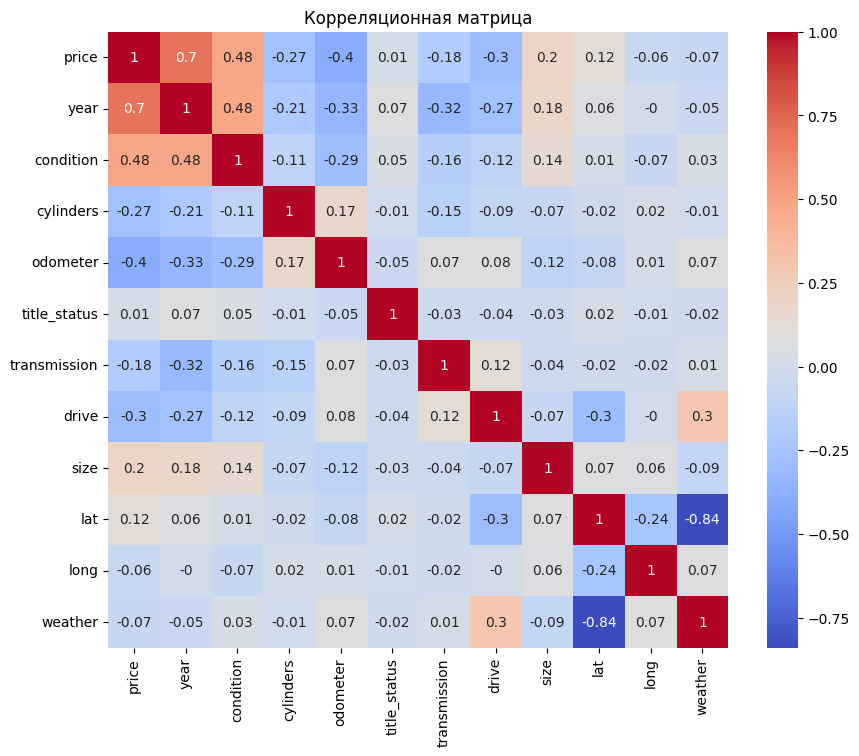

In [38]:
# Построим тепловую карту корреляции
numerical_data = df.select_dtypes(include='number') # оставим только числовые столбцы

plt.figure(figsize=(10, 8))
sns.heatmap(round(numerical_data.corr(), 2), annot=True, cmap='coolwarm')
plt.title("Корреляционная матрица")
plt.show()

Как видно, корреляционная матрица выявляет сильную связь между признаками  weather - lat и price - year. Поскольку признак price является целевым признаком и в дальнейшем будет отделяться от основной выборки, то логично оставить признак year для дальнейшего анализа. Признак lat будет удален.

In [39]:
# Удалим избыточный признак
df.drop('lat', axis = 1, inplace = True)

**Метод рекурсивного исключения признаков**

In [40]:
from sklearn.feature_selection import RFE

In [41]:
y = df['price']
x = df.drop(columns='price')

In [42]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=40)

In [43]:
estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train, y_train)
selector.get_feature_names_out()

array(['condition', 'drive', 'size'], dtype=object)

In [44]:
print('Три наиболее значимых признака по RFE:', selector.get_feature_names_out())

Три наиболее значимых признака по RFE: ['condition' 'drive' 'size']


In [45]:
# Сохраним три наиболее значимых признака по RFE в переменную main_columns_RFE
main_columns_RFE=selector.get_feature_names_out()

**Методы выбора признаков на основе фильтров**

In [46]:
from sklearn.feature_selection import SelectKBest, f_regression

In [47]:
selector = SelectKBest(f_regression, k=3)
selector.fit(X_train, y_train)

selector.get_feature_names_out()
print('Три наиболее значимых признака на основе фильтров SelectKBest:', selector.get_feature_names_out())

Три наиболее значимых признака на основе фильтров SelectKBest: ['year' 'condition' 'odometer']


In [48]:
# Сохраним три наиболее значимых признака по SelectKBest в переменную main_columns_SelectKBest
main_columns_SelectKBest=selector.get_feature_names_out()

**Обучение модели**

Подготовим данные для машинного обучения, выделим целевой признак, а затем разделим данные на обучающую и тестовую выборки

In [49]:
# Извлечем столбец price из датафрейма и сохраним в переменной y
y = df['price']
# Создадим новый датафрейм x, в котором присутствуют все столбцы из исходного датафрейма, кроме price
x = df.drop(columns='price')
# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=40)

Выполним обучение модели линейной регрессии на признаках, отобранных **методом RFE (Recursive Feature Elimination)**, а затем оценим качество модели с использованием метрики средней абсолютной ошибки (MAE)

In [50]:
# Обучим модель на наиболее значимых признака по RFE:
model = LinearRegression()
model.fit(X_train[main_columns_RFE], y_train)
y_predicted = model.predict(X_test[main_columns_RFE])

# Определим cреднюю абсолютную ошибку
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

MAE: 7080.184


Выполним обучение модели линейной регрессии на признаках, отобранных **методом SelectKBest**, и оценим качество модели с использованием метрики средней абсолютной ошибки (MAE)

In [51]:
# Обучим модель на наиболее значимых признака по SelectKBest:
model = LinearRegression()
model.fit(X_train[main_columns_SelectKBest], y_train)
y_predicted = model.predict(X_test[main_columns_SelectKBest])

# Определим cреднюю абсолютную ошибку
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

MAE: 4901.771


Выполним обучение модели линейной регрессии на всех доступных признаках, а затем оценим её качество с использованием метрики средней абсолютной ошибки (MAE)

In [52]:
# Обучим модель на всех признаках:
model = LinearRegression()
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)

# Определим cреднюю абсолютную ошибку
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

MAE: 4615.260


**Выводы:**
1. Лучший результат (наименьшая средняя абсолютная ошибка (MAE): 4615.260) был достигнут при обучении модели на всех доступных признаках, что говорит нам о том, что удаление некоторых признаков, даже с использованием методов отбора, привело к потере важной информации.
2. Метод SelectKBest показал себя лучше, чем метод RFE, но хуже, чем использование всех признаков. Средняя абсолютная ошибка (MAE) с использованием метода SelectKBest составила: 4901.771, что может быть связано с тем, что данный метод не полностью учел взаимосвязи между признаками, что могло повлиять на точность отбора наиболее значимых признаков.
3. Метод RFE оказался наименее эффективным методом отбора признаков (средняя абсолютная ошибка (MAE): 7080.184), что может указывать на то, что метод RFE не смог корректно отобрать наиболее значимые признаки для данной задачи.